In [1]:
%matplotlib inline

import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from hep2_classification.segmentation import SegmentationResult
from hep2_classification.presentation import display_grid, ImagePlotter

from numpy.random import seed
seed(123)


Using TensorFlow backend.


## dataset files count for each type

In [2]:
data_dir = '../data/segmented/'

def get_type_by_filename(filename):
    return filename.split('/')[-1].split('-')[0]

files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
files_dict = {}

for f in files:
    type_ = get_type_by_filename(f)
    files_list = files_dict.get(type_, [])
    files_dict[type_] = files_list + [f]
    
for k, v in files_dict.items():
    print(f'{k}: {len(v)}')

NEG: 153
ZIA: 32
NUC: 16
HOM: 30
DOT: 9
ACA: 36
FIB: 7
AMA: 5


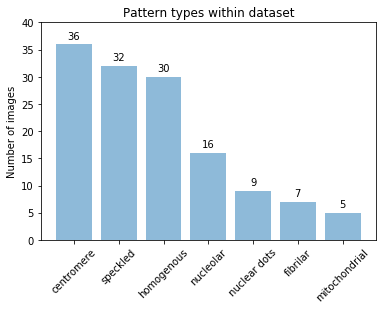

In [3]:
types = {
    'ACA': 'centromere',
    'ZIA': 'speckled',
    'HOM': 'homogenous',
    'NUC': 'nucleolar',
    'DOT': 'nuclear dots',
    'FIB': 'fibrilar',
    'AMA': 'mitochondrial'
}

y_pos = np.arange(len(types))
count = [len(files_dict[key]) for key in types.keys()]

plt.bar(y_pos, count, align='center', alpha=0.5)
plt.xticks(y_pos, types.values(), rotation=45)
plt.ylabel('Number of images')
plt.title('Pattern types within dataset')
plt.ylim((0, 40))

for i in range(len(count)):
    plt.text(x=y_pos[i]-(0.072 * len(str(count[i]))), y=count[i]+1, s=count[i], size=10)


## filtering out underrepresented types

In [4]:
filter_ = ['ZIA', 'HOM', 'ACA', 'NUC']

filtered_files = {k: v for k, v in files_dict.items() if k in filter_}
for k, v in filtered_files.items():
    print(f'{k}: {len(v)}')

ZIA: 32
NUC: 16
HOM: 30
ACA: 36


## splitting dataset to training and test sets

In [5]:
test_split = 0.3

train_files = {k: v[:-int(test_split * len(v))] for k, v in filtered_files.items()}
test_files = {k: v[-int(test_split * len(v)):] for k, v in filtered_files.items()}

print('training files:')
for k, v in train_files.items():
    print(f'{k}: {len(v)}')
    
print('\ntest files:')
for k, v in test_files.items():
    print(f'{k}: {len(v)}')

training files:
ZIA: 23
NUC: 12
HOM: 21
ACA: 26

test files:
ZIA: 9
NUC: 4
HOM: 9
ACA: 10


## extracting cells and balancing datasets

In [6]:
def load(files):
    cells = []
    index = 0
    
    for f in files:
        segmented = list(SegmentationResult.load(f).cells)
        cells += segmented
    
    return cells

def preprocess(cells, target_size):
    
    def middle_crop(cell):
        h, w = cell.shape
        shorter = min(h, w)
        
        h_skip = (h - shorter) // 2
        v_skip = (w - shorter) // 2
        
        return cell[h_skip:h_skip+shorter, v_skip:v_skip+shorter]
    
    new_cells = [cv2.resize(middle_crop(c), target_size) for c in cells]
    new_cells = np.array(new_cells) / 255
    new_cells = np.expand_dims(new_cells, axis=3)
    return new_cells

def create_generator(primary_class_files, secondary_class_files, cell_size, batch_size, **gen_params):
    primary_cells = load(primary_class_files)
    primary_cells = preprocess(primary_cells, cell_size)
    primary_labels = np.array([1] * len(primary_cells))
    
    secondary_cells = load(secondary_class_files)
    secondary_cells = preprocess(secondary_cells, cell_size)
    secondary_labels = np.array([0] * len(secondary_cells))
    
    all_cells = np.concatenate([primary_cells, secondary_cells])
    
    primary_generator = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    secondary_generator = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    half_batch = batch_size // 2
    
    for prim, sec in zip(
        primary_generator.flow(primary_cells, primary_labels, batch_size=half_batch),
        secondary_generator.flow(secondary_cells, secondary_labels, batch_size=half_batch)
    ):
        x_prim, y_prim = prim
        x_sec, y_sec = sec
        
        yield np.concatenate([x_prim, x_sec]), np.concatenate([y_prim, y_sec])
        
def load_dict(files_dict, main_class):
    cells = []
    labels = []
    
    for type_, files in files_dict.items():
        label = 1 if (type_ == main_class) else 0
        print(type_, label)
        for f in files:
            segmented = list(SegmentationResult.load(f).cells)
            cells += segmented
            labels += (len(segmented) * [label])

    labels = np.array(labels)
    
    return cells, labels        

def load_dict_dataset(files_dict, cell_size, main_class):
    cells, labels = load_dict(files_dict, main_class)
    cells = preprocess(cells, cell_size)
        
    return cells, labels

## building model

In [11]:
cell_size = (96, 96)

model_input = keras.Input(shape=(cell_size[0], cell_size[1], 1), name='img')
x = layers.Conv2D(8, 11, activation='relu')(model_input)
x = layers.Conv2D(16, 11, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(16, 7, activation='relu')(x)
x = layers.Conv2D(32, 7, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 5, activation='relu')(x)
x = layers.Conv2D(64, 5, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
model_output = layers.Dense(1, activation='sigmoid')(x)

base_model = keras.Model(model_input, model_output, name='cells-classifier')
base_model.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 86, 86, 8)         976       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 76, 76, 16)        15504     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        12560     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 32)        25120     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)   

## training multiple one vs all binary classifiers

In [14]:
batch_size = 128
epochs = 20
steps_per_epoch = 10

models = {}

for primary_class in filter_:
    primary_files = train_files[primary_class]
    secondary_files = []

    for k, v in train_files.items():
        if k != primary_class:
            secondary_files += v

    generator = create_generator(primary_files, secondary_files, cell_size, batch_size)
    
    X_val, y_val = load_dict_dataset(test_files, cell_size, main_class=primary_class)

    model = keras.models.clone_model(base_model)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    history = model.fit_generator(
        generator,
        validation_data=(X_val, y_val),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs
    )
    
    models[primary_class] = model, history

ZIA 1
NUC 0
HOM 0
ACA 0
Epoch 1/20
10/10 [==============================] - 22s 2s/step - loss: 0.6884 - acc: 0.4969 - val_loss: 0.7070 - val_acc: 0.3247
Epoch 2/20
10/10 [==============================] - 18s 2s/step - loss: 0.6834 - acc: 0.6267 - val_loss: 0.5993 - val_acc: 0.6934
Epoch 3/20
10/10 [==============================] - 19s 2s/step - loss: 0.5937 - acc: 0.6531 - val_loss: 0.4604 - val_acc: 0.7220
Epoch 4/20
10/10 [==============================] - 18s 2s/step - loss: 0.5520 - acc: 0.7205 - val_loss: 0.4417 - val_acc: 0.8021
Epoch 5/20
10/10 [==============================] - 19s 2s/step - loss: 0.5176 - acc: 0.7969 - val_loss: 0.4072 - val_acc: 0.7652
Epoch 6/20
10/10 [==============================] - 18s 2s/step - loss: 0.5068 - acc: 0.7621 - val_loss: 0.3851 - val_acc: 0.7819
Epoch 7/20
10/10 [==============================] - 19s 2s/step - loss: 0.4374 - acc: 0.7961 - val_loss: 0.4789 - val_acc: 0.7310
Epoch 8/20
10/10 [==============================] - 18s 2s/step - 

10/10 [==============================] - 19s 2s/step - loss: 0.6705 - acc: 0.5662 - val_loss: 0.6490 - val_acc: 0.7777
Epoch 4/20
10/10 [==============================] - 18s 2s/step - loss: 0.6561 - acc: 0.6019 - val_loss: 0.5084 - val_acc: 0.8383
Epoch 5/20
10/10 [==============================] - 18s 2s/step - loss: 0.6936 - acc: 0.5496 - val_loss: 0.7161 - val_acc: 0.2976
Epoch 6/20
10/10 [==============================] - 18s 2s/step - loss: 0.6798 - acc: 0.6127 - val_loss: 0.6094 - val_acc: 0.7923
Epoch 7/20
10/10 [==============================] - 18s 2s/step - loss: 0.6594 - acc: 0.5915 - val_loss: 0.7225 - val_acc: 0.4355
Epoch 8/20
10/10 [==============================] - 18s 2s/step - loss: 0.6638 - acc: 0.6293 - val_loss: 0.5504 - val_acc: 0.8007
Epoch 9/20
10/10 [==============================] - 18s 2s/step - loss: 0.6620 - acc: 0.5675 - val_loss: 0.5655 - val_acc: 0.8223
Epoch 10/20
10/10 [==============================] - 19s 2s/step - loss: 0.6443 - acc: 0.6667 - val_l

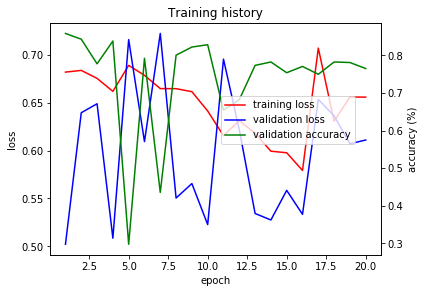

In [16]:
_, history = models['NUC']

train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

x = list(range(1, len(train_loss) + 1))

# plt.plot(x, train_loss, c='red', label='training loss')
# plt.plot(x, val_loss, c='blue', label='validation loss')
# plt.legend()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(x, train_loss, color='red', label='training loss')
ax1.plot(x, val_loss, color='blue', label='validation loss')
ax2 = ax1.twinx()

ax2.set_ylabel('accuracy (%)')
ax2.plot(x, val_acc, color='green', label='validation accuracy')

fig.tight_layout()
fig.legend(loc='lower left', bbox_to_anchor=(0.5, 0.5))

# plt.ylim((0, 1.3))
plt.title("Training history")
plt.show()

(array([1232.,    0.,    0.,  203.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <a list of 4 Patch objects>)

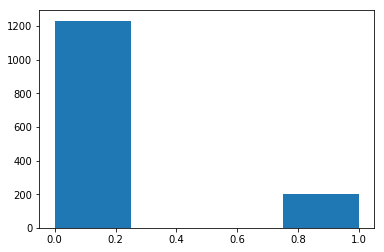

In [17]:
plt.hist(y_val, bins=4)

In [22]:
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
validation = (test_pred == y_test)
np.mean(validation)

0.7037337662337663

In [69]:
incorrect_X = X_test[validation == False]
incorrect_X = incorrect_X.reshape(incorrect_X.shape[:3])
incorrect_true_y = y_test[validation == False]
incorrect_pred_y = test_pred[validation == False]
titles = [f'true: {t}, pred: {p}' for t, p in zip(incorrect_true_y, incorrect_pred_y)]

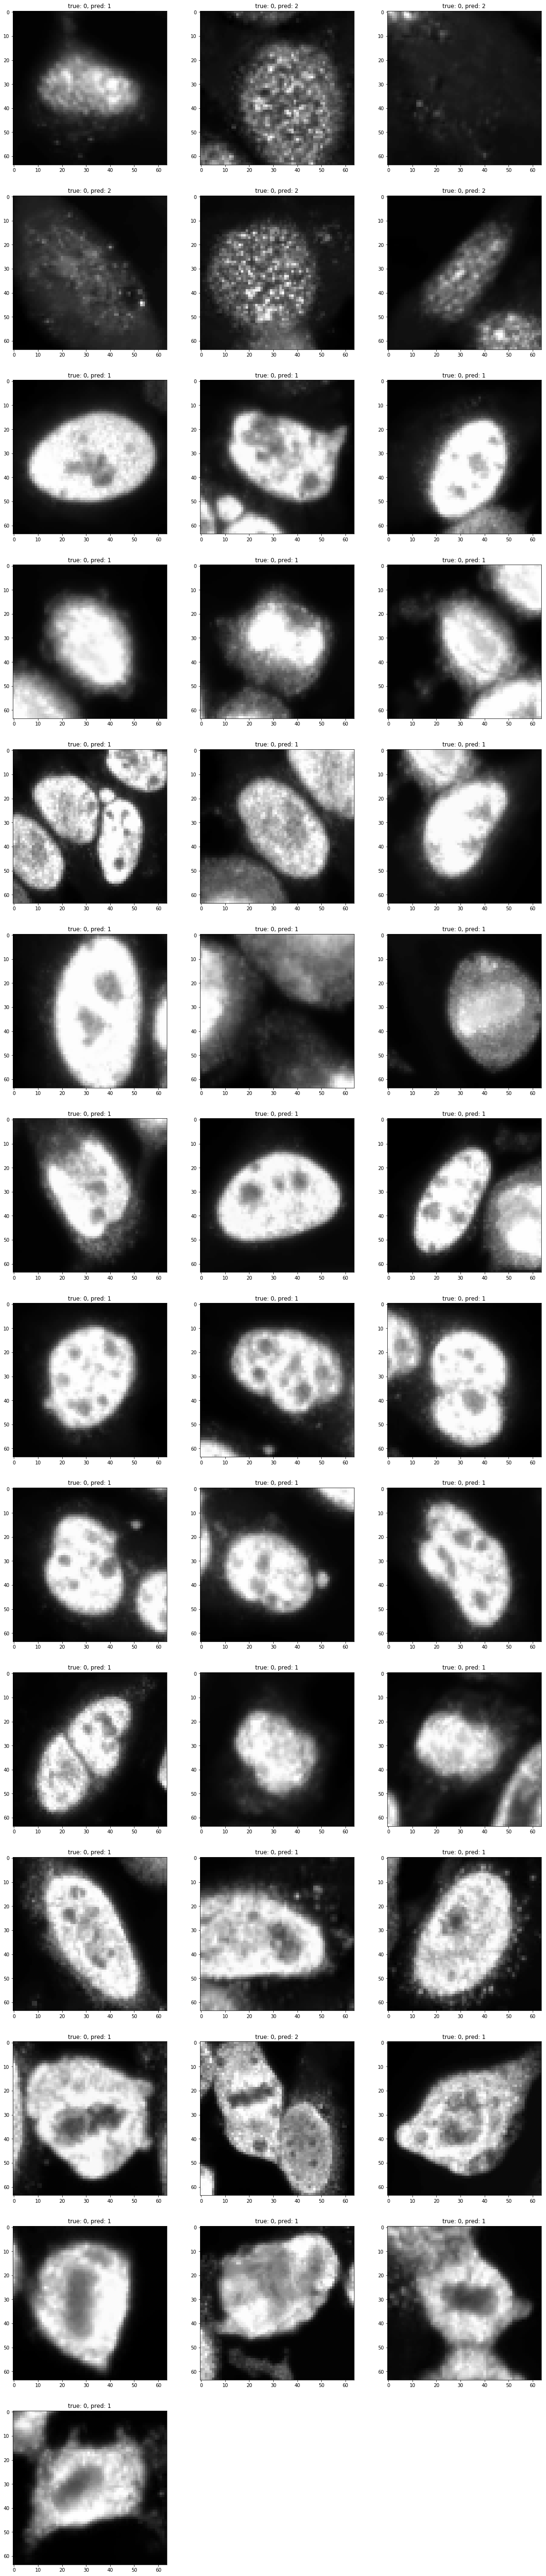

In [70]:
display_grid(incorrect_X[:40], ImagePlotter(), titles=titles[:40])